In [12]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST 
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(0) 

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [19]:
def get_generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True)
    )


class Generator(nn.Module):
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim*8,im_dim),
            nn.Sigmoid(),
        )
    def forward(self, noise):
        return self.gen(noise)

In [3]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples,z_dim,device=device)

In [4]:
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim,output_dim),
        nn.LeakyReLU(0.2,inplace=True)
    )

class Discriminator(nn.Module):
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim,1)
        )

    def forward(self, image):
        return self.disc(image)

In [20]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001

dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [22]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    fake_noise = get_noise(num_images,z_dim,device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss

In [23]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

In [24]:
# cur_step = 0
# mean_generator_loss = 0
# mean_discriminator_loss = 0
# test_generator = True 
# gen_loss = False
# error = False

# g_losses = []
# d_losses = []

# for epoch in range(n_epochs):
  
#     for real, _ in tqdm(dataloader):
#         cur_batch_size = len(real)

#         real = real.view(cur_batch_size, -1).to(device)
#         disc_opt.zero_grad()
#         disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
#         disc_loss.backward(retain_graph=True)
#         disc_opt.step()
#         if test_generator:
#             old_generator_weights = gen.gen[0][0].weight.detach().clone()
#         gen_opt.zero_grad()
#         gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
#         gen_loss.backward()
#         gen_opt.step()
        
#         g_losses.append(gen_loss.item())
#         d_losses.append(disc_loss.item())
        
#         mean_discriminator_loss += disc_loss.item() / display_step
#         mean_generator_loss += gen_loss.item() / display_step

#         if cur_step % display_step == 0 and cur_step > 0:
#             print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
#             fake_noise = get_noise(cur_batch_size, z_dim, device=device)
#             fake = gen(fake_noise)
#             show_tensor_images(fake)
#             show_tensor_images(real)
#             mean_generator_loss = 0
#             mean_discriminator_loss = 0
#         cur_step += 1
#     if epoch != 0 and epoch%10==0:
#         torch.save(gen.state_dict(), f"weights/gen_{epoch}.pth")
#         torch.save(disc.state_dict(), f"weights/dic_{epoch}.pth")

In [21]:
# torch.save(gen.state_dict(), f"genenerator.pth")
# torch.save(disc.state_dict(), f"discriminator.pth")

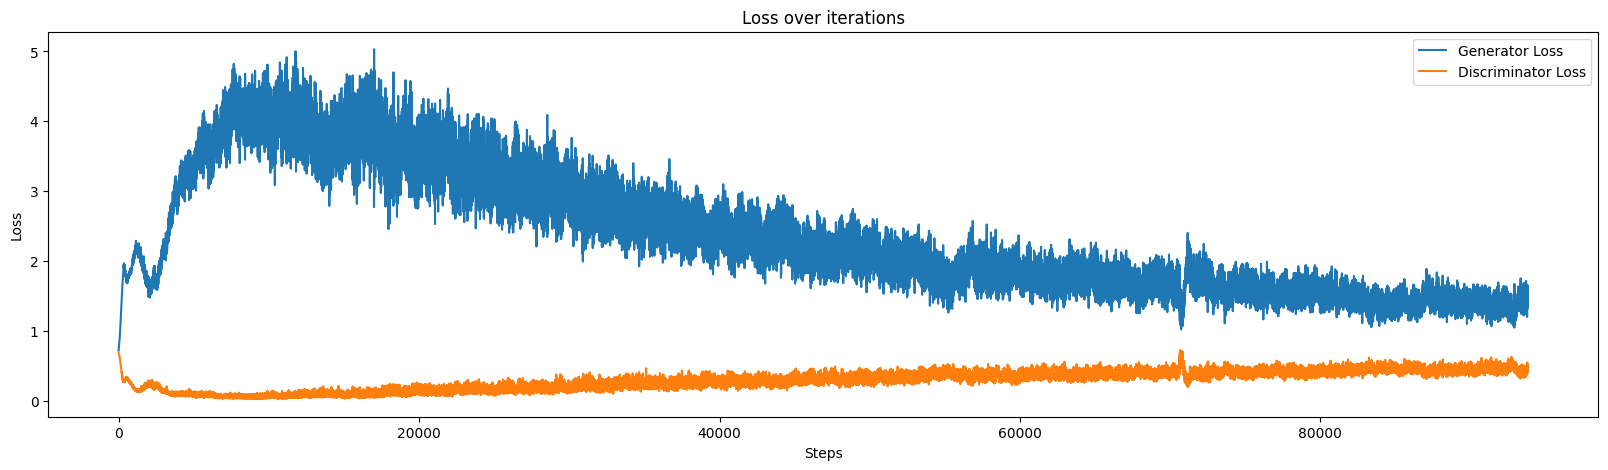

In [33]:
# plt.figure(figsize=(20,5))
# plt.plot(g_losses, label="Generator Loss")
# plt.plot(d_losses, label="Discriminator Loss")
# plt.xlabel('Steps')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Loss over iterations')
# plt.show()

In [34]:
# import json
# with open('g_losses.json', 'w') as f:
#     json.dump(g_losses, f)
# with open('d_losses.json', 'w') as f:
#     json.dump(d_losses, f)

In [ ]:
# with open('g_losses.json', 'r') as f:
#     g_losses = json.load(f)
# with open('d_losses.json', 'r') as f:
#     d_losses = json.load(f)

In [10]:
gen.load_state_dict(torch.load('/kaggle/input/some/pytorch/default/1/genenerator.pth'))
disc.load_state_dict(torch.load('/kaggle/input/some/pytorch/default/1/discriminator.pth'))

<All keys matched successfully>

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC

In [26]:
class DiscFeatures(nn.Module):
    def __init__(self, im_dim=784, hidden_dim=128):
        super(DiscFeatures, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim,1)
        )

    def forward(self, x):
        features = x.view(x.size(0), -1)  
        for layer in self.disc[:-1]:
            features = layer(features)
        validity = self.disc[-1](features)
        return validity, features
    
disc = DiscFeatures().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [27]:
disc.load_state_dict(torch.load('/kaggle/input/some/pytorch/default/1/discriminator.pth'))

<All keys matched successfully>

In [28]:
def extract_features(discriminator, data_loader):
    discriminator.eval()
    features, labels = [], []
    with torch.no_grad():
        for imgs, lbls in data_loader:
            imgs = imgs.to(device)
            _, feats = discriminator(imgs)
            features.append(feats.cpu().numpy())
            labels.append(lbls.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)

image_size = 28
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataloader = DataLoader(
    MNIST('.', download=False, transform=transform),
    batch_size=batch_size,
    shuffle=True)

train_features, train_labels = extract_features(disc, dataloader)

In [29]:
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

In [30]:
X_train.shape

(48000, 128)

In [31]:
X_val.shape

(12000, 128)

In [32]:
base_classifiers = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('svc', SVC(C=1.0, tol=0.0001, max_iter=1000, random_state=42, probability=True))
]
# base_classifiers = [
#     ('xgb', XGBClassifier(n_estimators=50, use_label_encoder=False, eval_metric='logloss',device='cuda')),
#     ('lgbm', LGBMClassifier(n_estimators=50, device='gpu'))
# ]

In [ ]:
meta_classifier = LogisticRegression(tol=0.0001, max_iter=100, C=1.0, random_state=42)
stacking_clf = StackingClassifier(
    estimators=base_classifiers, 
    final_estimator=meta_classifier,
    cv=5,  
    n_jobs=-1  
)

stacking_clf.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [ ]:
accuracy = stacking_clf.score(X_val, y_val)
print(f"Stacking Classifier Accuracy: {accuracy:.4f}")